In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
from torchvision.models import resnet18, resnet101

In [5]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [3]:



class CNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNLSTM, self).__init__()
        self.resnet = resnet101(pretrained=True)
        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 300))
        self.lstm = nn.LSTM(input_size=300, hidden_size=256, num_layers=3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
       
    def forward(self, x_3d):
        hidden = None
        for t in range(x_3d.size(1)):
            with torch.no_grad():
                x = self.resnet(x_3d[:, t, :, :, :])  
            out, hidden = self.lstm(x.unsqueeze(0), hidden)         

        x = self.fc1(out[-1, :, :])
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [2]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="tarian/train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="tarian/validation", target_size=(224,224))

Found 1444 images belonging to 3 classes.
Found 610 images belonging to 3 classes.


In [3]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [5]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')


In [ ]:
hist = model.fit_generator(steps_per_epoch=10,generator=traindata, validation_data= testdata, validation_steps=10,epochs=10,callbacks=[checkpoint,early])
#hist = model.fit(steps_per_epoch=10,generator=traindata, validation_data= testdata, validation_steps=10,epochs=10,callbacks=[checkpoint,early])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/10
10/10 [==============================] - 752s 75s/step - loss: 191.8910 - accuracy: 0.4589 - val_loss: 1.2042 - val_accuracy: 0.2844
Epoch 2/10
10/10 [==============================] - 841s 84s/step - loss: 1.2292 - accuracy: 0.5250 - val_loss: 0.9734 - val_accuracy: 0.4500
Epoch 3/10
10/10 [==============================] - 828s 83s/step - loss: 0.5921 - accuracy: 0.7156 - val_loss: 0.6665 - val_accuracy: 0.7219
Epoch 4/10


In [29]:
model.save_weights('coba.h5')

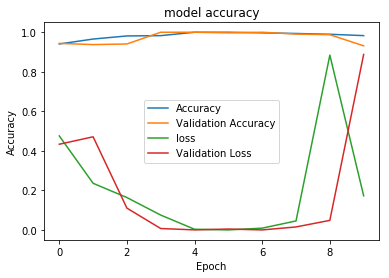

In [30]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

ValueError: No model found in config file.

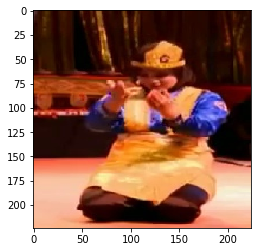

In [7]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing import image
img = image.load_img("opo.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

from tensorflow.keras.models import load_model
saved_model = load_model("coba.h5")

#saved_model = load_model("vgg16_1.h5")
output = model.predict(img)
print (output)
if (output[0][0] > output[0][1]) and (output[0][0] > output[0][2]) : print ('gambyong')
if (output[0][1] > output[0][0]) and (output[0][1] > output[0][2]) : print ('pendet')
if (output[0][2] > output[0][0]) and (output[0][2] > output[0][1]) : print ('saman')
    


In [41]:
print (output[0][0])
print (output[0][1])
print (output[0][2])


1.1827591e-31
0.0
1.0


[[1.1827591e-31 0.0000000e+00 1.0000000e+00]]
saman


True

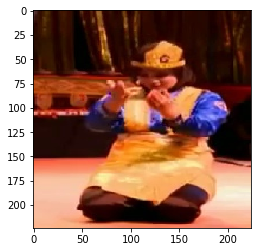

In [50]:

import cv2
from tensorflow.keras.preprocessing import image
img = image.load_img("opo.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
#from tensorflow.keras.models import load_model
#saved_model = load_model("coba.h5")

#saved_model = load_model("vgg16_1.h5")
output = model.predict(img)
print (output)
if (output[0][0] > output[0][1]) and (output[0][0] > output[0][2]) : textnya = 'gambyong'
if (output[0][1] > output[0][0]) and (output[0][1] > output[0][2]) : textnya = 'pendet'
if (output[0][2] > output[0][0]) and (output[0][2] > output[0][1]) : textnya = 'saman'
print (textnya)
    
import cv2
im = cv2.imread('opo.jpg')
font = cv2.FONT_HERSHEY_SIMPLEX
#cv2.putText(im, textnya, (10,450), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
cv2.putText(im,'Hack Projects',(10,500), font, 1,(255,255,255),2)

cv2.imwrite('jaditext.jpg', im)

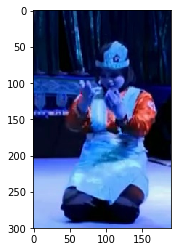

In [47]:
plt.imshow(im)

In [8]:
import cv2
# Read the image
img = cv2.imread('opo.jpg')
# initialize counter
i = 0
while True:
    # Display the image
    cv2.imshow('a',img)
    # wait for keypress
    k = cv2.waitKey(0)
    # specify the font and draw the key using puttext
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,chr(k),(10+i,250), font, .5,(255,255,255),2,cv2.LINE_AA)
    i+=10
    if k == ord('q'):
        break
cv2.destroyAllWindows()